<시작하세요! 텐서플로 2.0 프로그래밍> 예제코드입니다.

- 예제 코드를 실행하기 위해서는 [파일] > [드라이브에 사본 저장]으로 본인의 계정에 사본을 만든 다음 실행하면 됩니다.
- 예제 코드는 [깃허브 저장소](https://github.com/wikibook/tf2)에서도 동일하게 제공됩니다. 예제에 대한 질문이나 책에 대한 질문은 깃허브 저장소의 [Issues](https://github.com/wikibook/tf2/issues)에 올려주세요.
- 각 장의 예제 파일은 처음부터 끝까지 실행하는 상황을 가정하고 작성되었습니다. 혹시 세션이 다운되는 등의 이유로 실행이 되지 않는 경우가 있다면, 필요한 라이브러리를 import 하신 후에 실행하시면 됩니다. (tensorflow, numpy, pandas 등)

In [ ]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np

# 9.5 이미지 분할(Segmentation)

2020.05.04 현재 tfds에서 oxford_iiit_pet 데이터세트가 정상적으로 로드되지 않는 문제가 있습니다. 
https://github.com/wikibook/tf2/issues/10

현재 [tensorflow 측에서 해결중](<https://github.com/tensorflow/datasets/issues/1978>)이며, 해결되는대로 이 파일을 지우도록 하겠습니다. 그때까지는 9.5 단원의 학습은 이 파일을 사용해주시면 좋겠습니다.


In [ ]:
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

2020-05-04 11:50:56.320595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0504 11:50:58.205005 140161469831040 download_and_prepare.py:180] Running download_and_prepare for datasets:
oxford_iiit_pet:3.1.0
I0504 11:50:58.205702 140161469831040 download_and_prepare.py:181] Version: "None"
I0504 11:50:58.206328 140161469831040 dataset_builder.py:202] Load pre-computed datasetinfo (eg: splits) from bucket.
I0504 11:50:58.312199 140161469831040 dataset_info.py:431] Loading info from GCS for oxford_iiit_pet/3.1.0
I0504 11:50:58.995512 140161469831040 download_and_prepare.py:130] download_and_prepare for dataset oxford_iiit_pet/3.1.0...
I0504 11:50:58.996093 140161469831040 dataset_builder.py:310] Generating dataset oxford_iiit_pet (/root/tensorflow_datasets/oxford_iiit_pet/3.1.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0504 11:50:59.15

In [ ]:
# 9.36 Oxford Pet Dataset 불러오기
import tensorflow_datasets as tfds
# dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)
dataset, info = tfds.load('oxford_iiit_pet:3.1.0', with_info=True)

In [ ]:
# 9.37 Dataset 정보 확인
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and J

In [ ]:
# 9.38 train, test 데이터 수 저장
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples

In [ ]:
# 9.39 이미지 로드 함수 정의
def load_image(datapoint):
    img = tf.image.resize(datapoint['image'], (128, 128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask -= 1
    
    return img, mask

In [ ]:
# 9.40 train, test Dataset 정의
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

0.3996089 0.00047392002


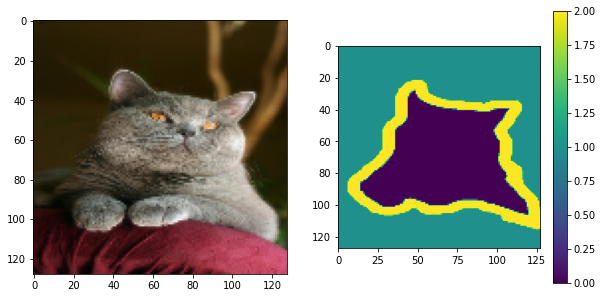

In [ ]:
# 9.41 이미지, 마스크 확인
import matplotlib.pyplot as plt
for img, mask in train_dataset.take(1):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img[2])
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(mask[2], axis=2))
    plt.colorbar()

    print(np.amax(img[1][2]), np.amin(img[1][2]))

In [ ]:
# 9.42 Segmentation을 위한 REDNet 네트워크 정의
def REDNet_segmentation(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = tf.keras.layers.Input(shape=(None, None, 3))
    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='softmax'))

    x = conv_layers[0](inputs)

    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i % 2 == 0:
            residual_layers.append(x)

    for i in range(num_layers-1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x) 

    x = deconv_layers[-1](x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [ ]:
# 9.43 Segmentation을 위한 REDNet 네트워크 초기화 및 컴파일
model = REDNet_segmentation(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 9.44 Segmentation을 위한 REDNet 네트워크 학습
history = model.fit(train_dataset,
                    epochs=20,
                    steps_per_epoch=train_data_len//16, 
                    validation_data=test_dataset, 
                    validation_steps=test_data_len)

Epoch 1/20
230/230 [==============================] - 85s 369ms/step - loss: 0.8688 - accuracy: 0.5821 - val_loss: 0.8454 - val_accuracy: 0.5798
Epoch 2/20
230/230 [==============================] - 85s 370ms/step - loss: 0.7602 - accuracy: 0.6227 - val_loss: 0.7519 - val_accuracy: 0.6420
Epoch 3/20
230/230 [==============================] - 85s 370ms/step - loss: 0.7097 - accuracy: 0.6733 - val_loss: 0.6777 - val_accuracy: 0.6991
Epoch 4/20
230/230 [==============================] - 85s 370ms/step - loss: 0.6529 - accuracy: 0.7132 - val_loss: 0.6257 - val_accuracy: 0.7340
Epoch 5/20
230/230 [==============================] - 85s 371ms/step - loss: 0.6205 - accuracy: 0.7332 - val_loss: 0.5985 - val_accuracy: 0.7482
Epoch 6/20
230/230 [==============================] - 86s 372ms/step - loss: 0.5938 - accuracy: 0.7465 - val_loss: 0.5862 - val_accuracy: 0.7559
Epoch 7/20
230/230 [==============================] - 85s 370ms/step - loss: 0.5699 - accuracy: 0.7585 - val_loss: 0.5650 - val_ac

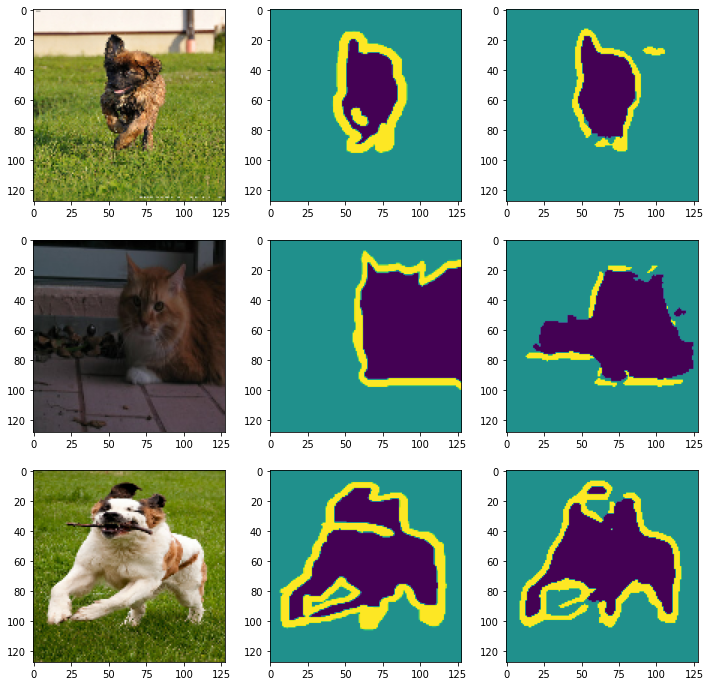

In [ ]:
# 9.45 테스트 이미지 분할 확인
plt.figure(figsize=(12, 12))
for idx, (img, mask) in enumerate(test_dataset.take(3)):
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img[0])
    
    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask[0], axis=2))
    
    predict = tf.argmax(model.predict(img), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    # plt.imshow(np.squeeze(predict[0], axis=0))
    plt.imshow(np.squeeze(predict, axis=0))

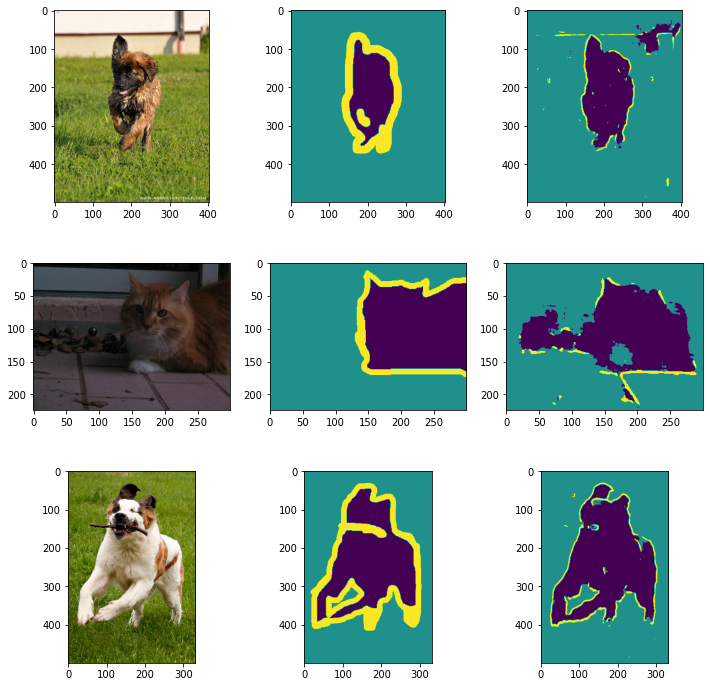

In [ ]:
# 9.46 테스트 이미지 분할 확인(원본)
plt.figure(figsize=(12, 12))
for idx, datapoint in enumerate(dataset['test'].take(3)):
    img = datapoint['image']
    mask = datapoint['segmentation_mask']
    
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask -= 1
    
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img)
    
    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask, axis=2))
    
    predict = tf.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    # plt.imshow(np.squeeze(predict[0], axis=0))
    plt.imshow(np.squeeze(predict, axis=0))